In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [2]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2, 2).transpose(0,2,1).reshape(-1,2)).reshape(-1, 2, 2).transpose(0,2,1).reshape(data.shape)
    return scaled_data

file_name = "planar_orbits_400_200"
data = np.load("data/" + file_name + ".npz")
data, params = data["data"], data["params"]

H, L, phi0, e, a = params.T
data = preprocess(data, MaxAbsScaler)

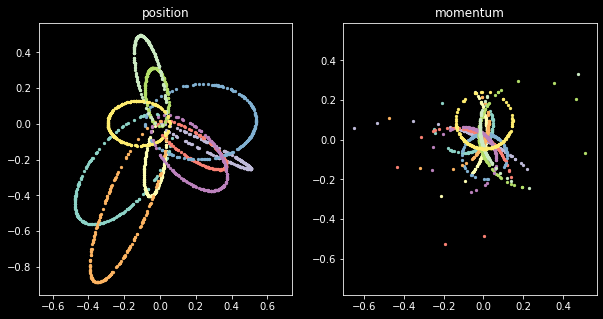

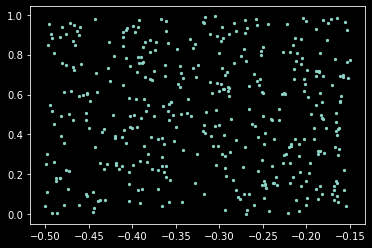

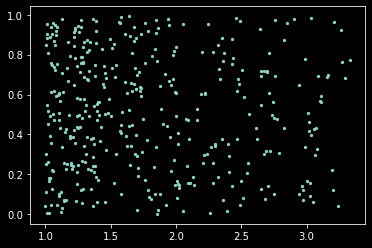

In [3]:
mu = 1
A = np.sqrt(mu**2+2*H*L**2)

plt.figure(figsize=(10, 5))
plt.subplot(121)
for traj in data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=5.)
plt.axis('equal')
plt.title("position")

plt.subplot(122)
for traj in data[:10]:
    plt.scatter(traj[:,2], traj[:,3], s=5.)
plt.axis('equal')
plt.title("momentum")

plt.figure()
plt.scatter(H, L, s=5)
plt.figure()
plt.scatter(a, L, s=5);

Converged? True
[]


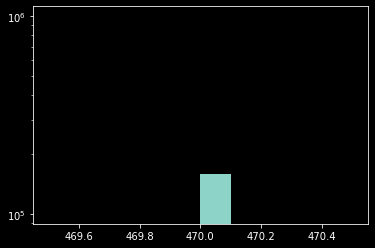

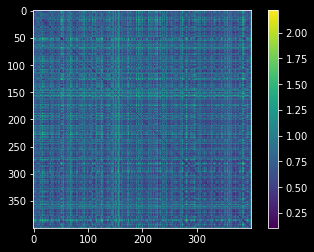

In [4]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [5]:
# np.savez(file_name + "_dist_mat.npz", dist_mat=dist_mat)
# dist_mat = np.load(file_name + "_dist_mat.npz")['dist_mat']

In [61]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=200, alpha=1, robust=True)

nn_max = 1.2760268449783325
epsilon = 3.256489018210715
mean_shift = 0.0031546098


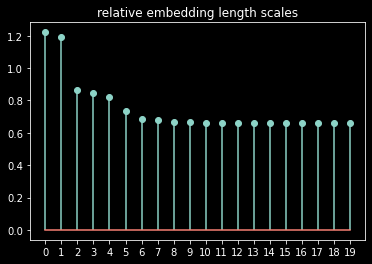

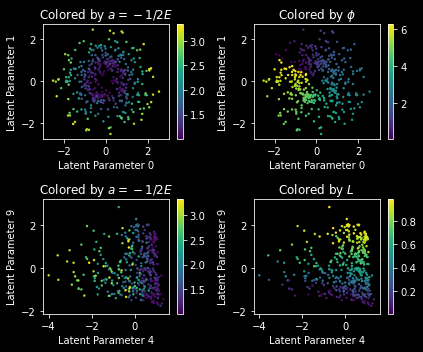

In [68]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(6,5))
plt.subplot(221)
plt.scatter(embedding[:,0], embedding[:,1], c=a, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $a=-1/2E$")
plt.axis('equal')

plt.subplot(222)
plt.scatter(embedding[:,0], embedding[:,1], c=phi0, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 1")
plt.title("Colored by $\phi$")
plt.axis('equal')

plt.subplot(223)
plt.scatter(embedding[:,4], embedding[:,5], c=a, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 4")
plt.ylabel("Latent Parameter 9")
plt.title("Colored by $a=-1/2E$")
plt.axis('equal')

plt.subplot(224)
plt.scatter(embedding[:,4], embedding[:,5], c=L, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 4")
plt.ylabel("Latent Parameter 9")
plt.title("Colored by $L$")
plt.axis('equal')
plt.tight_layout()

# plt.savefig("embedding.pdf", bbox_inches='tight')

[0, 1, 5]


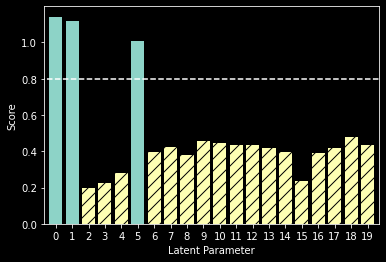

In [63]:
threshold = 0.8
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="standard")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

[0, 1, 5]


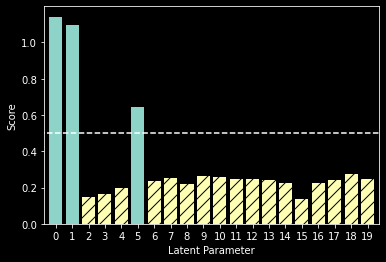

In [64]:
threshold = 0.5
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass[:n_components])
plt.bar(list(range(n_components)), scores_fail[:n_components], hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

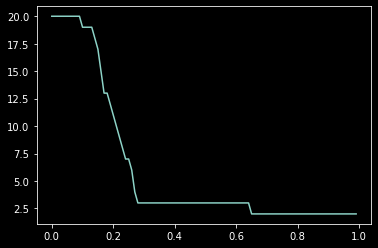

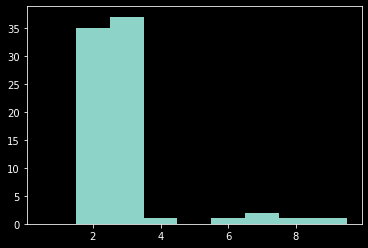

In [65]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

0.9871027697912469


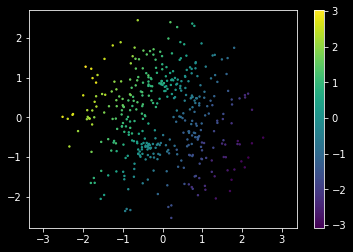

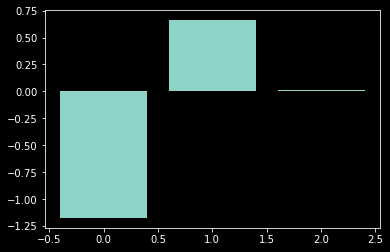

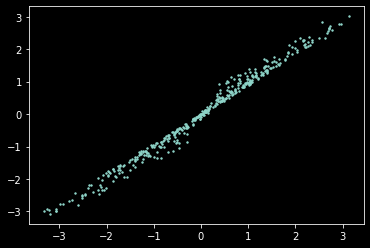

In [66]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = a*np.cos(phi0)

plt.scatter(embedding[:,0], embedding[:,1], c=y, s=2)
plt.colorbar()
plt.axis('equal');

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

0.9268528822218571


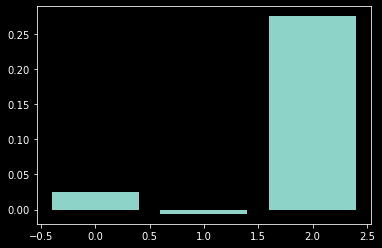

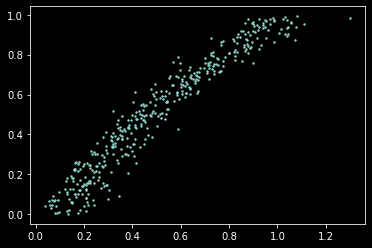

In [67]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = L
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
plt.figure()
plt.bar(range(reg.coef_.shape[0]), reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);